# Implementation of the spectral sparsifier proposed in "Graph Sparsification by Effective Resistance"

In [2]:
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import scipy as sp
import random as rd

## The following functions return different kind of matrices associated to graphs

In [3]:
#IN THE FOLLOWING LINES OF CODES GRAPHS Gs ARE REPRESENTED BY NETWORKX OBJECTS

#receive an integer n
#return an undirected unweighted complete graph of n vertices
def get_complete_undirected_graph(n):
    Kn = nx.complete_graph(n)
    return Kn

def get_complete_weighted_random_graph(n, w):
    Kn = nx.complete_graph(n)
    for (u,v) in Kn.edges():
        Kn.edges[u,v]['weight'] = w*(1-rd.uniform(0,1))
    return Kn

#receive a graph G
#return the adjacency matrix of G as numpy array object
def get_adjacency_matrix(G):
    A = nx.adjacency_matrix(G)
    return A.toarray()

#receive a graph G
#return the Laplacian matrix of G as numpy array object
def get_laplacian_matrix(G):
    L = nx.laplacian_matrix(G)
    return L.toarray()

#receive a graph G
#return the nxm signed Incidence matrix of G as numpy array object
def get_signed_incidence_matrix(G):
    B = nx.incidence_matrix(G, oriented=True)
    return B.toarray()

#Returns a mxm diagonal matrix with the weight of every edge at every diagonal entry 
def get_weight_diagonal_matrix(G):
    return np.diag(get_edge_weights(G))

#Returns a nxn diagonal matrix with the degree of every vertex as entry
def get_weighted_degree_matrix(G):
    n = G.number_of_nodes()
    return np.diag([G.degree(weight='weight')[i] for i in range(n)])

#receive a graph G
#returns the vectors corresponding to every edge of G (the column vectos of the signed incidence matrix)
def get_rank_one_laplacian_decomposition(G):
    B = nx.incidence_matrix(G, oriented=True)
    m = G.number_of_edges()
    Vs = [] #vectors vi
    for i in range(m):
        u = B[:,i]
        Vs.append(u.toarray())
    return Vs

#Returns the pseudoinverse a given matrix
def get_pseudoinverse(A):
    return np.linalg.pinv(A)

#Returns a matrix to the power of t
def get_matrix_tothe_power_of(A, t):
    return sp.linalg.fractional_matrix_power(A,t)

#Returns the Normalized Laplacian of a given graph G
def get_normalized_laplacian(G):
    L = get_laplacian_matrix(G)
    D = get_weighted_degree_matrix(G)
    Dsq = get_matrix_tothe_power_of(D,-0.5)
    return Dsq@L@Dsq

#Returns the effective resistnace matrix R
def get_effective_resistance_matrix(G):
    L = get_laplacian_matrix(G)
    B = get_signed_incidence_matrix(G)
    Lplus = get_pseudoinverse(L)
    return B.transpose()@Lplus@B

#Returns the effective ressistance of every edge of G in a list
def get_effective_resistances(G):
    R = get_effective_resistance_matrix(G)
    m = R.shape[0]
    eff = []
    for i in range(m):
        eff.append(R[i,i])
    return eff

#Return a list of the edge weights of a graph G
def get_edge_weights(G):
    return [G.edges[(i,j)]['weight'] for (i,j) in G.edges]

#Return an undirected weighted graph given a Laplacian matrix
def get_graph_from_laplacian(L):
    H = nx.Graph()
    n = L.shape[0]
    for i in range(n):
        for j in range(i+1,n):
            if (L[i,j] != 0):
                H.add_edge(i,j,weight = L[i,j])
    return H

## Here we define the main function

In [4]:
def Sparsify(G,q):
    n = len(G.nodes)
    eff = get_effective_resistances(G)
    m = len(eff)
    weights = np.array(get_edge_weights(G))
    ps = weights*eff/(n-1)
    print(sum(ps))
    S = np.zeros(m)
    for _ in range(q):
        i = np.random.choice(m, p=ps)
        S[i] += (1/q)*ps[i]
    print(S.shape)
    reweighted_edges = S*weights
    Sm = np.diag(reweighted_edges)
    B = get_signed_incidence_matrix(G)
    #W = get_weight_diagonal_matrix(G)
    return B@Sm@B.transpose()

def get_parameter_q(C, n):
    e = (1+(1/np.sqrt(n)))/5
    print("Approximation factor: ",e)
    return int(9*(C**2)*n*np.log2(n)/(e**2))

## From here we test the spectral sparsifier

In [5]:
#We define the graph to sparsify and compute its associated matrices
n = 20
q = get_parameter_q(5e-2,n)
G = get_complete_weighted_random_graph(n,1)
NL = get_normalized_laplacian(G)
LH = Sparsify(G,q)
#print(LH)

Approximation factor:  0.2447213595499958
1.0000000000000002
(190,)


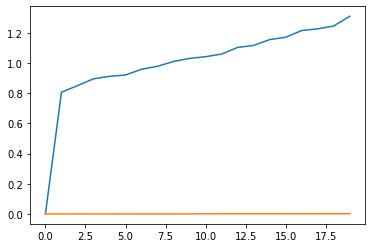

In [6]:
#From here we test how approximated are the graphs
eigvals = LA.eigh(NL)[0]
eigvals1 = LA.eigh(LH)[0]
#plt.plot(eigvals1)
plt.plot(eigvals)
plt.plot(eigvals1)

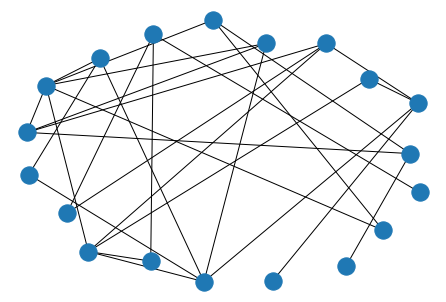

In [7]:
H = get_graph_from_laplacian(LH)
nx.draw(H)

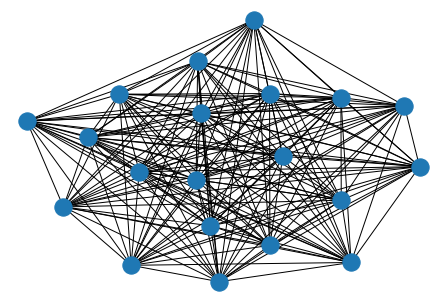

In [8]:
nx.draw(G)
#print(G.degree(weight='weight'))

In [ ]:
#I am gonna construct the matrix PI
W = get_weighted_degree_matrix(G)
Wsq = get_matrix_tothe_power_of(W,0.5)
R = get_effective_resistance_matrix(G)
PI = Wsq@R@Wsq
print(PI)

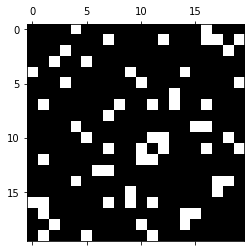

In [452]:
plt.spy(LH)